In [1]:

!pip install optree


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Found 8192 images belonging to 5 classes.
Found 2046 images belonging to 5 classes.


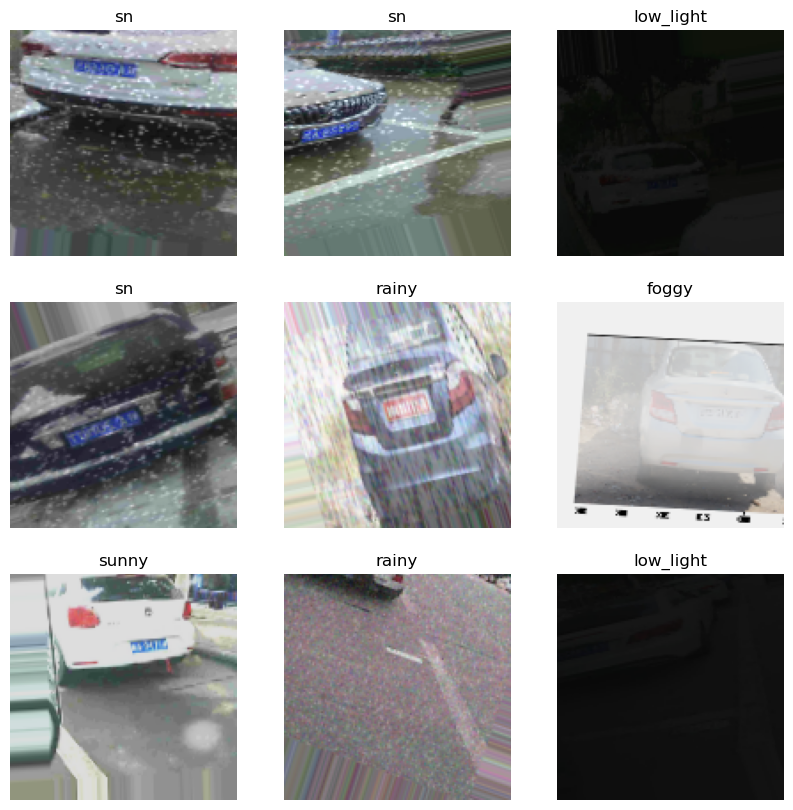

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define image dimensions and batch size
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Optimized Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,  # Reduced from 40
    width_shift_range=0.2,  # Reduced from 0.4
    height_shift_range=0.2,  # Reduced from 0.4
    shear_range=0.2,  # Reduced from 0.4
    zoom_range=0.2,  # Reduced from 0.4
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]  # Reduced range
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load Training Data
train_data = train_datagen.flow_from_directory(
    'D:/fypfinal/yolo_dataset/images',  # Ensuring correct path
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=42
)

# Load Validation Data
val_data = val_datagen.flow_from_directory(
    'D:/fypfinal/yolo_dataset/images',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,  # Ensuring batch size consistency
    class_mode='categorical',
    subset='validation',
    seed=42
)

# Display Sample Images
class_names = list(train_data.class_indices.keys())
images, labels = next(train_data)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.show()

# Callbacks for Training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 🟢 Load Pretrained ResNet50 (With ImageNet Weights)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base layers to retain learned features


# 🟢 Freeze Lower Layers (So they don't train)
for layer in base_model.layers[:100]:  # Freezing first 100 layers
    layer.trainable = False

# 🟢 Adding Custom Classification Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  # 5-class classification

# 🟢 Define Final Model
model = Model(inputs=base_model.input, outputs=output)

# 🟢 Compile Model with Adam Optimizer
optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)  
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 🟢 Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6)
model_checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True, mode='min')

# 🟢 Print Model Summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 134, 134, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 64, 64, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 64, 64, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 64, 64, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 66, 66, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 32, 32, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 32, 32, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 32, 32, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 24,147,333 (92.11 MB)

 Trainable params: 558,853 (2.13 MB)

 Non-trainable params: 23,588,480 (89.98 MB)

In [27]:


# Train the model
epochs = 10
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=val_data,
    callbacks=[early_stopping]
)
# Save the model
model.save("weather_classifier.keras")

Epoch 1/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - accuracy: 0.4022 - loss: 1.8545 - val_accuracy: 0.3658 - val_loss: 1.7366
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 385s 1s/step - accuracy: 0.6279 - loss: 1.0478 - val_accuracy: 0.6466 - val_loss: 0.7875
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.6891 - loss: 0.8935 - val_accuracy: 0.7471 - val_loss: 0.6776
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.7267 - loss: 0.7648 - val_accuracy: 0.7623 - val_loss: 0.6758
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 429s 1s/step - accuracy: 0.7454 - loss: 0.7089 - val_accuracy: 0.8337 - val_loss: 0.4894
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 468s 1s/step - accuracy: 0.7595 - loss: 0.6549 - val_accuracy: 0.5796 - val_loss: 1.5418
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 478s 2s/step - accuracy: 0.7678 - loss: 0.6333 - val_accuracy: 0.7068 - val_loss: 0.7535
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - accuracy: 0.7902 - loss: 0.5804 - val_accu

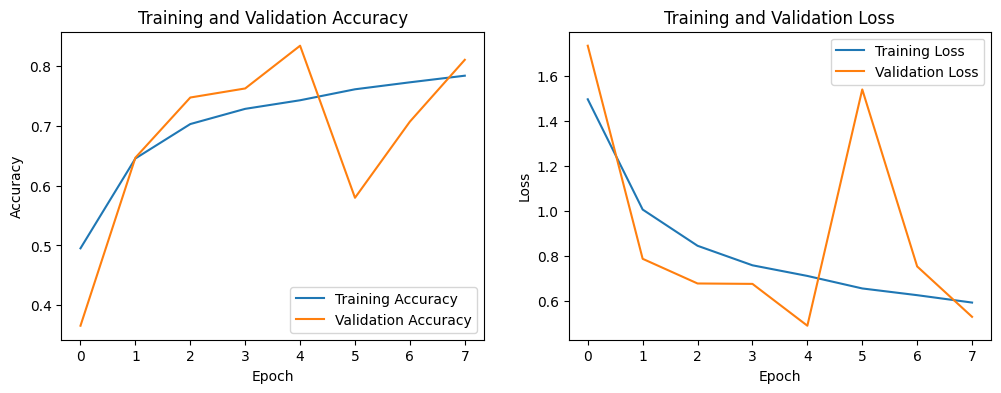

In [28]:
# Plot the training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [29]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_data)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


79/79 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8397 - loss: 0.4773
Validation Loss: 0.4894316494464874
Validation Accuracy: 0.8336657285690308


In [10]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

In [4]:
# --- Low Light Enhancement ---
def enhance_low_light_image(image, brightness_factor=1.2):
    yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
    y, u, v = cv2.split(yuv_image)
    y = cv2.equalizeHist(y)
    y = np.clip(y * brightness_factor, 0, 255).astype(np.uint8)
    enhanced_yuv = cv2.merge([y, u, v])
    return cv2.cvtColor(enhanced_yuv, cv2.COLOR_YUV2BGR)

In [5]:
# --- Foggy Image Enhancement ---
def dark_channel_prior(image, size=15):
    image = image.astype(np.float32)
    dark_channel = np.min(image, axis=2)
    dark_channel = cv2.erode(dark_channel, np.ones((size, size)))
    return dark_channel

def estimate_atmospheric_light(image, dark_channel):
    max_dark_value = np.max(dark_channel)
    atmospheric_light = image[np.where(dark_channel == max_dark_value)]
    return np.mean(atmospheric_light, axis=0)

def recover_image(image, dark_channel, atmospheric_light, omega=0.95, t0=0.1):
    transmission = 1 - omega * dark_channel / atmospheric_light[0]
    transmission = np.clip(transmission, t0, 1)
    recovered_image = (image - atmospheric_light[0]) / (transmission[..., None] + 0.1) + atmospheric_light[0]
    return np.clip(recovered_image, 0, 255).astype(np.uint8)

def apply_dcp(image):
    dark_channel = dark_channel_prior(image)
    atm_light = estimate_atmospheric_light(image, dark_channel)
    return recover_image(image, dark_channel, atm_light)


In [6]:
# --- Sunny Image Enhancement ---
def enhance_sunny_image(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.normalize(v, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    hsv_enhanced = cv2.merge([h, s, v])
    enhanced_image = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)
    lab = cv2.cvtColor(enhanced_image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_enhanced = clahe.apply(l)
    lab_enhanced = cv2.merge([l_enhanced, a, b])
    final_image = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)
    return final_image


In [7]:
# --- Rainy Image Enhancement ---
def denoise_rainy_image(img):
    img = cv2.resize(img, (768, 1024))
    bilateral = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)
    gray = cv2.cvtColor(bilateral, cv2.COLOR_BGR2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    morph = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel, iterations=1)
    morph_color = cv2.cvtColor(morph, cv2.COLOR_GRAY2BGR)
    rain_reduced = cv2.subtract(bilateral, morph_color)
    rain_cleaned = cv2.add(img, rain_reduced)
    denoised = cv2.fastNlMeansDenoisingColored(rain_cleaned, None, 5, 5, 7, 21)
    lab = cv2.cvtColor(denoised, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    contrast = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    sharpened = cv2.filter2D(contrast, -1, np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]]))
    return cv2.resize(sharpened, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)

In [8]:
# --- Snowy Image Enhancement (similar to rainy) ---
def denoise_snow_image(img):
    return denoise_rainy_image(img)  # You can customize if needed

In [9]:
# Load trained model (rename1.keras must be in your notebook directory or provide full path)
model = load_model(r"E:\downloads new\rename1.keras")

# Define your weather condition classes
class_labels = ['foggy', 'lowlight', 'rainy', 'snowy', 'sunny']

NameError: name 'load_model' is not defined

In [138]:
# Load and preprocess the image
img_path = r"D:\fypfinal\yolo_dataset\images\rainy\005626197318-90_85-329,468_482,516-469,509_335,508_333,467_467,468-0_0_17_32_25_27_1-83-21.jpg" # Or full path like "D:/fypdataset/test.jpg"
original_img = cv2.imread(img_path)
resized_img = cv2.resize(original_img, (128, 128))
rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
img_normalized = rgb_img / 255.0
input_tensor = np.expand_dims(img_normalized, axis=0)

# Predict
predictions = model.predict(input_tensor)
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_labels[predicted_class_index]
print("Predicted Weather Condition:", predicted_class_name)

[2025-05-14 01:07:30,553] [ WARNING] polymorphic_function.py:157 - 5 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001513F5E4E00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Weather Condition: rainy


In [139]:
# Apply appropriate enhancement
if predicted_class_name == "foggy":
    enhanced_img = apply_dcp(original_img)
elif predicted_class_name == "sunny":
    enhanced_img = enhance_sunny_image(original_img)
elif predicted_class_name == "lowlight":
    enhanced_img = enhance_low_light_image(original_img)
elif predicted_class_name == "rainy":
    enhanced_img = denoise_rainy_image(original_img)
elif predicted_class_name == "snowy":
    enhanced_img = denoise_snow_image(original_img)
else:
    enhanced_img = original_img.copy()
    print("Unknown condition - no enhancement applied.")

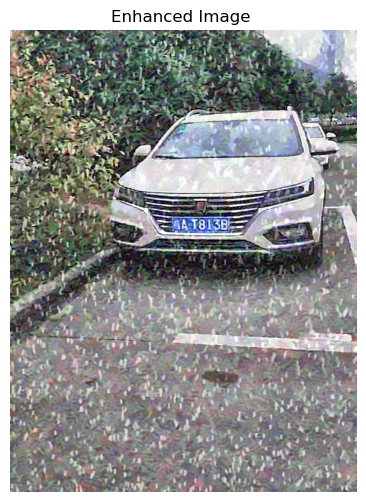

In [140]:
# Convert BGR to RGB for display
enhanced_img_rgb = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(enhanced_img_rgb)
plt.title(f"Enhanced Image ")
plt.axis('off')
plt.show()

In [141]:
import os
import cv2

# Path to store image count
count_file_path = r"C:\Users\HP\Desktop\cleaning result\image_count.txt"

# Load image count from file or initialize to 0
if os.path.exists(count_file_path):
    with open(count_file_path, 'r') as f:
        image_count = int(f.read())
else:
    image_count = 0

# Define output directory
output_dir = r"C:\Users\HP\Desktop\cleaning result"
os.makedirs(output_dir, exist_ok=True)

# Define output path using image count
enhanced_img_path = os.path.join(output_dir, f"image{image_count}.jpg")
# Save the enhanced image (assuming `enhanced_img` exists)
cv2.imwrite(enhanced_img_path, enhanced_img)
print(f"Enhanced image saved at: {output_path}")

# Increment and save updated image count
image_count += 1
with open(count_file_path, 'w') as f:
    f.write(str(image_count))


Enhanced image saved at: C:\Users\HP\Desktop\cleaning result\image3.jpg


YOLO detection completed.


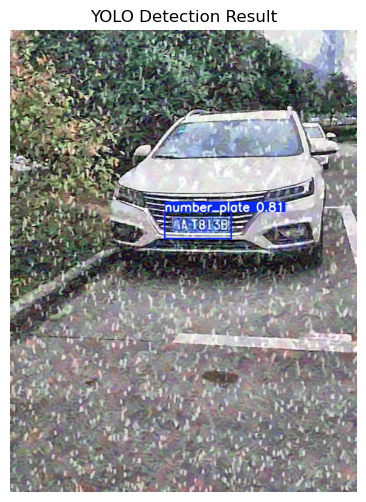

In [142]:


# === YOLO Detection ===

yolo_model_path = r"D:\fypfinal\last\bestyolo.pt"

yolo_output_dir = r"C:\Users\HP\Desktop\yolo_output"

yolo_command = (
    f'yolo task=detect mode=predict model="{yolo_model_path}" conf=0.25 '
    f'source="{enhanced_img_path}" save=True '
    f'project="{yolo_output_dir}" name="result1" exist_ok=True'
)

subprocess.run(yolo_command, shell=True)
print("YOLO detection completed.")

# === Display YOLO Output ===

detected_output_img = os.path.join(yolo_output_dir, "result1", os.path.basename(enhanced_img_path))
if os.path.exists(detected_output_img):
    output_img = cv2.imread(detected_output_img)
    output_img_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(output_img_rgb)
    plt.title("YOLO Detection Result")
    plt.axis('off')
    plt.show()
else:
    print("⚠️ YOLO result image not found.")

In [143]:
import os
import cv2
from ultralytics import YOLO
from paddleocr import PaddleOCR

# Initialize PaddleOCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Load YOLO model
model = YOLO(r"D:\fypfinal\last\bestyolo.pt")
image_path = enhanced_img_path

# Output base folder
output_base = r"C:\Users\HP\Desktop\new_ocr\paddleocr"
os.makedirs(output_base, exist_ok=True)

# Find next available folder with incremented index
def get_next_output_folder(base_path):
    counter = 1
    while True:
        output_folder = os.path.join(base_path, f"run_{counter}")
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
            return output_folder
        counter += 1

output_folder = get_next_output_folder(output_base)

# Read image
image = cv2.imread(image_path)
results = model(image)[0]

ocr_texts = []

for i, box in enumerate(results.boxes):
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    cropped = image[y1:y2, x1:x2]

    # Run PaddleOCR
    result = ocr.ocr(cropped, cls=True)
    plate_text = result[0][0][1][0] if result and result[0] else ""
    ocr_texts.append(plate_text)

    # Annotate and save cropped plate
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2.putText(image, plate_text, (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
    cv2.imwrite(os.path.join(output_folder, f"plate_{i}.jpg"), cropped)

# Save annotated image and OCR text
cv2.imwrite(os.path.join(output_folder, "annotated.jpg"), image)
with open(os.path.join(output_folder, "ocr.txt"), "w") as f:
    f.write("\n".join(ocr_texts))

print("OUTPUT SAVED IN:", output_folder)
print("PaddleOCR Output:", ocr_texts)


[2025/05/14 01:09:58] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\HP/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\HP/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max

In [3]:
# JUST PROVIDE THE PATH TO THE IMAGE YOU WANT TO PROCESS
image_path = "D:/fypfinal/yolo_dataset/images/rainy/003125-90_85-297,521_404,564-394,567_295,563_296,529_395,533-0_0_30_32_27_24_32-100-14.jpg"  # 👈 CHANGE THIS TO YOUR NEW IMAGE PATH

# NOW CALL THE FINAL FUNCTION THAT GENERATES OUTPUT
generate_output(image_path)


NameError: name 'generate_output' is not defined

In [95]:
!pip install paddleocr paddlepaddle pytesseract opencv-python

  Using cached astor-0.8.1-py2.py3-none-any.whl.metadata (4.2 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
   ---------------------------------------- 0.0/97.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/97.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/97.1 MB ? eta -:--:--
   ---------------------------------------- 0.8/97.1 MB 2.0 MB/s eta 0:00:49
   ---------------------------------------- 1.0/97.1 MB 1.5 MB/s eta 0:01:03
    --------------------------------------- 1.3/97.1 MB 1.9 MB/s eta 0:00:52
    --------------------------------------- 1.3/97.1 MB 1.9 MB/s eta 0:00:52
    --------------------------------------- 1.3/97.1 MB 1.9 MB/s eta 0:00:52
    --------------------------------------- 1.3/97.1 MB 1.9 MB/s eta 0:00:52
    --------------------------------------- 1.6/97.1 MB 856.1 kB/s eta 0:01:52
    --------------------------------------- 1.8/97.1 MB 883.1 kB/s eta 0:01:48
    ---------------------------------

NameError: name 'preprocess_image_based_on_condition' is not defined

   ---------------------------------------- 0.0/921.5 kB ? eta -:--:--
   ---------------------- ----------------- 524.3/921.5 kB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 921.5/921.5 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.3.49
    Uninstalling ultralytics-8.3.49:
      Successfully uninstalled ultralytics-8.3.49


TESTING YOLO ON THE ENTIRE DATASET...

image 1/1 E:\downloads new\process\process\test\foggy\images\00480363984674-90_87-486,404_615,444-618,451_491,452_490,404_617,403-0_0_16_32_0_24_27-63-18.jpg: 128x96 1 number_plate, 39.9ms
Speed: 5.6ms preprocess, 39.9ms inference, 19.8ms postprocess per image at shape (1, 3, 128, 96)

image 1/1 E:\downloads new\process\process\test\foggy\images\00481082375479-96_85-420,485_538,541-523,536_423,522_427,487_527,501-0_0_29_26_25_20_28-85-8.jpg: 128x96 1 number_plate, 16.9ms
Speed: 0.5ms preprocess, 16.9ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 96)

image 1/1 E:\downloads new\process\process\test\foggy\images\00481920498084-90_90-279,402_408,461-401,460_280,457_281,411_402,414-0_0_8_25_20_27_27-65-3.jpg: 128x96 (no detections), 16.9ms
Speed: 0.5ms preprocess, 16.9ms inference, 0.6ms postprocess per image at shape (1, 3, 128, 96)

image 1/1 E:\downloads new\process\process\test\foggy\images\00482279693486-93_86-302,510_427,554-432,

In [ ]:
from ultralytics import YOLO
import cv2
import os
import pytesseract
import numpy as np

# SET TESSERACT OCR PATH (MODIFY THIS BASED ON YOUR SYSTEM)
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# PATH TO THE DIRECTORY CONTAINING TEST IMAGES
test_images_path = r"D:\fypfinal\yolo_dataset\processed_images\foggy"

# PATH TO THE DIRECTORY WHERE RESULTS WILL BE SAVED
output_path = r"D:\fypfinal\yolo_dataset\r"
os.makedirs(output_path, exist_ok=True)

# LOAD THE TRAINED YOLO MODEL
model_path = r"D:\fypfinal\last\bestyolo.pt"  # REPLACE WITH YOUR MODEL PATH
model = YOLO(model_path)

# LOOP THROUGH EACH IMAGE IN THE TEST DIRECTORY
for image_name in os.listdir(test_images_path):
    image_path = os.path.join(test_images_path, image_name)
    
    # PERFORM INFERENCE ON THE IMAGE
    results = model(image_path, conf=0.5)  # ADJUST CONFIDENCE THRESHOLD
    
    # LOOP THROUGH THE RESULTS
    for result in results:
        # GET THE BOUNDING BOXES
        boxes = result.boxes.xyxy.cpu().numpy()  # BOUNDING BOX COORDINATES IN [X1, Y1, X2, Y2] FORMAT
        confidences = result.boxes.conf.cpu().numpy()  # CONFIDENCE SCORES
        class_ids = result.boxes.cls.cpu().numpy()  # CLASS IDS (IF MULTIPLE CLASSES ARE DETECTED)
        
        # LOAD THE ORIGINAL IMAGE
        image = cv2.imread(image_path)
        
        # LOOP THROUGH EACH DETECTED BOUNDING BOX
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)  # CONVERT COORDINATES TO INTEGERS
            
            # CROP THE DETECTED NUMBER PLATE REGION
            number_plate_roi = image[y1:y2, x1:x2]
            
            # SAVE THE CROPPED ROI (OPTIONAL)
            roi_path = os.path.join(output_path, f"roi_{image_name}")
            cv2.imwrite(roi_path, number_plate_roi)
            
            # PREPROCESS THE CROPPED IMAGE FOR OCR
            gray_roi = cv2.cvtColor(number_plate_roi, cv2.COLOR_BGR2GRAY)  # CONVERT TO GRAYSCALE
            _, thresh_roi = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # APPLY THRESHOLDING
            
            # PERFORM OCR USING TESSERACT
            plate_text = pytesseract.image_to_string(thresh_roi, config='--psm 7')  # PSM 7 FOR SINGLE LINE TEXT
            
            # CLEAN AND FORMAT THE EXTRACTED TEXT
            plate_text = plate_text.strip()  # REMOVE LEADING/TRAILING WHITESPACE
            plate_text = "".join(c for c in plate_text if c.isalnum())  # REMOVE SPECIAL CHARACTERS
            
            # PRINT THE EXTRACTED TEXT
            print(f"DETECTED NUMBER PLATE: {plate_text}")
            
            # DRAW THE BOUNDING BOX AND TEXT ON THE ORIGINAL IMAGE
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, plate_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
        # SAVE THE ANNOTATED IMAGE
        output_image_path = os.path.join(output_path, f"annotated_{image_name}")
        cv2.imwrite(output_image_path, image)

print("OCR AND NUMBER PLATE EXTRACTION COMPLETED!")



image 1/1 D:\fypfinal\yolo_dataset\processed_images\foggy\00478448275862-93_84-382,564_514,606-516,614_388,602_386,559_514,571-0_0_7_26_10_33_32-83-16.jpg: 128x96 (no detections), 128.7ms
Speed: 9.2ms preprocess, 128.7ms inference, 11.9ms postprocess per image at shape (1, 3, 128, 96)

image 1/1 D:\fypfinal\yolo_dataset\processed_images\foggy\00478448275862-93_88-443,408_565,461-556,457_444,454_446,416_558,419-0_0_27_31_31_29_32-68-14.jpg: 128x96 (no detections), 41.5ms
Speed: 0.9ms preprocess, 41.5ms inference, 1.3ms postprocess per image at shape (1, 3, 128, 96)

image 1/1 D:\fypfinal\yolo_dataset\processed_images\foggy\00478807471264-90_90-276,523_418,556-418,564_278,563_278,518_418,519-0_0_15_16_25_25_28-116-34.jpg: 128x96 1 number_plate, 33.9ms
Speed: 0.7ms preprocess, 33.9ms inference, 13.8ms postprocess per image at shape (1, 3, 128, 96)
DETECTED NUMBER PLATE: 

image 1/1 D:\fypfinal\yolo_dataset\processed_images\foggy\00480363984674-90_86-246,441_371,486-371,485_244,485_244,44

In [7]:
from ultralytics import YOLO
import os
import cv2

model = YOLO(r'D:\fypfinal\last\bestyolo.pt')

test_images_dir = r'D:\fypfinal\last\denoised_results'
output_dir = r'D:\fypfinal\last\ocr denoised_results'
os.makedirs(output_dir, exist_ok=True)

image_files = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))][:10]

for img_name in image_files:
    img_path = os.path.join(test_images_dir, img_name)
    results = model(img_path, conf=0.25, imgsz=640)

    for r in results:
        print(f"\nImage: {img_name}")
        print("Boxes:", r.boxes)
        print("Scores:", r.boxes.conf if r.boxes is not None else "No boxes")
        print("Classes:", r.boxes.cls if r.boxes is not None else "No classes")
        result_img = r.plot()
        cv2.imwrite(os.path.join(output_dir, img_name), result_img)


image 1/1 D:\fypfinal\last\denoised_results\denoised_frame0.jpg: 384x640 1 number_plate, 117.8ms
Speed: 6.7ms preprocess, 117.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

Image: denoised_frame0.jpg
Boxes: ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.])
conf: tensor([0.8674])
data: tensor([[155.9892, 167.5610, 187.3747, 182.3908,   0.8674,   0.0000]])
id: None
is_track: False
orig_shape: (360, 640)
shape: torch.Size([1, 6])
xywh: tensor([[171.6819, 174.9759,  31.3856,  14.8298]])
xywhn: tensor([[0.2683, 0.4860, 0.0490, 0.0412]])
xyxy: tensor([[155.9892, 167.5610, 187.3747, 182.3908]])
xyxyn: tensor([[0.2437, 0.4654, 0.2928, 0.5066]])
Scores: tensor([0.8674])
Classes: tensor([0.])

image 1/1 D:\fypfinal\last\denoised_results\denoised_frame1.jpg: 384x640 1 number_plate, 129.7ms
Speed: 2.2ms preprocess, 129.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

Image: denoised_frame1.jpg
Boxes: ultralytics.engine.results.